# Constants

In [3]:
# Data Generation
num_funcs = 10
noise = 0.00

# Network Structure
input_dim = 2
hidden_dim = 50
output_dim = 2
num_layers = 2

# Training Process
num_epochs = 10000
batch_size = 210

# Data Generation

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [5]:
# Define system matrices
A = np.array([[-1, 2], [-3, -4]])
B = np.array([[1, 0], [0, 1]])
C = np.array([[1, 0], [0, 1]])
D = np.array([[0, 0], [0, 0]])

global currentFunc

randomConditions = np.random.random(size=(num_funcs, 2)) + 0.1

# Define initial conditions and time span
x0 = np.array([1, 1])
tspan = np.linspace(0, 10.5, batch_size)  # Time vector (batch_size,)

# Define input function
def u(t, sin, cos):
    return np.array(
        [
            (sin * np.sin(sin * t)) + (np.random.random()) * noise,
            (cos * np.cos(cos * t)) + (np.random.random()) * noise,
        ]
    )

# Define the state-space system as a function
def dxdt(t, x):
    global currentFunc
    return (
        (np.random.random()) * noise
        + A @ x
        + B @ u(t, randomConditions[currentFunc][0], randomConditions[currentFunc][1])
    )


offset = 0
u_values = np.zeros((len(tspan)*num_funcs, 2))
y = np.zeros((len(tspan)*num_funcs, 2))

for i in range(num_funcs):
    currentFunc = i
    # Solve the system using solve_ivp with specified time vector
    sol = solve_ivp(dxdt, [tspan[0], tspan[-1]], x0, t_eval=tspan)

    # Calculate the output y(t)
    # y = np.zeros((len(sol.t), 2))
    for j in range(len(sol.t)):
        y[offset + j, :] = (
            (np.random.random()) * noise
            + C @ sol.y[:, j]
            + D @ u(sol.t[j], randomConditions[i][0], randomConditions[i][1])
        )

    # Calculate the input u(t) for saving and plotting
    # u_values = np.zeros((len(sol.t), 2))
    for j in range(len(sol.t)):
        u_values[offset + j, :] = u(
            sol.t[j], randomConditions[i][0], randomConditions[i][1]
        )

    print(f"Generated function: {i}, w/ random conditions {randomConditions[i]}")

    offset += len(sol.t) # Ensure arrays won't overlap

Generated function: 0, w/ random conditions [0.83350506 0.71052046]
Generated function: 1, w/ random conditions [0.42445424 0.99098554]
Generated function: 2, w/ random conditions [0.96563574 0.41676073]
Generated function: 3, w/ random conditions [0.88129802 0.94957809]
Generated function: 4, w/ random conditions [0.56287147 0.82909879]
Generated function: 5, w/ random conditions [0.34145891 0.32432174]
Generated function: 6, w/ random conditions [0.72634396 1.01276512]
Generated function: 7, w/ random conditions [0.39144608 1.01317684]
Generated function: 8, w/ random conditions [0.63361521 0.2647348 ]
Generated function: 9, w/ random conditions [0.33040128 0.48560117]


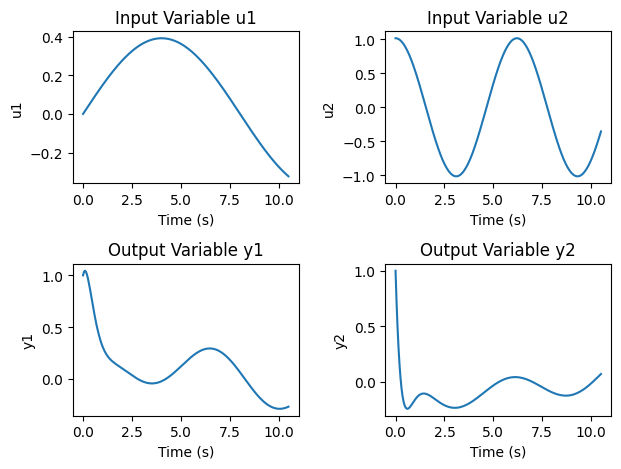

In [11]:
target_func = np.random.randint(0,num_funcs)

plt.figure()

plt.subplot(2,2,1)
plt.plot(sol.t, u_values[target_func * batch_size : batch_size + target_func * batch_size, 0])
plt.xlabel('Time (s)')
plt.ylabel('u1')
plt.title('Input Variable u1')

plt.subplot(2,2,2)
plt.plot(sol.t, u_values[target_func * batch_size : batch_size + target_func * batch_size :, 1])
plt.xlabel('Time (s)')
plt.ylabel('u2')
plt.title('Input Variable u2')

plt.subplot(2, 2, 3)
plt.plot(sol.t, y[target_func * batch_size : batch_size + target_func * batch_size :, 0])
plt.xlabel('Time (s)')
plt.ylabel('y1')
plt.title('Output Variable y1')

plt.subplot(2, 2, 4)
plt.plot(sol.t, y[target_func * batch_size : batch_size + target_func * batch_size :, 1])
plt.xlabel('Time (s)')
plt.ylabel('y2')
plt.title('Output Variable y2')

plt.tight_layout()
plt.show()

In [291]:
extended_span = np.arange(0, 10.5*num_funcs, 0.05) # Scale for all functions

# Sample DataFrame
data = {
    'time':  extended_span,
    'a': u_values[:,0],
    'b': u_values[:,1],
    'c': y[:,0],
    'd': y[:,1]
}
df = pd.DataFrame(data)

print(df)
# Ensure time is the index
df.set_index('time', inplace=True)

def create_sequences(df, seq_length):
    inputs = []
    outputs = []

    for i in range(len(df) - seq_length):
        inputs.append(df[['c', 'd']].iloc[i:i+seq_length].values)
        outputs.append(df[['a', 'b']].iloc[i+seq_length].values)

    return np.array(inputs), np.array(outputs)

seq_length = 10  # Example sequence length

X, y = create_sequences(df, seq_length)


class DynamicsDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        if len(self.X) != len(self.Y):
            raise Exception("len(X) must equal len(Y)")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        _x = self.X[index]
        _y = self.Y[index]

        return _x, _y


# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Load into dataset
data = DynamicsDataset(X, y)

        time         a         b         c         d
0       0.00  0.009401  0.526913  1.000764  1.000764
1       0.05  0.035109  0.530067  1.039513  0.708825
2       0.10  0.063179  0.529083  1.052949  0.468733
3       0.15  0.094748  0.530340  1.035488  0.263642
4       0.20  0.122137  0.523477  1.012315  0.106896
...      ...       ...       ...       ...       ...
2095  104.75  0.036156 -0.272661 -0.026625 -0.040601
2096  104.80  0.035962 -0.266084 -0.032377 -0.043463
2097  104.85  0.030657 -0.253996 -0.035432 -0.043799
2098  104.90  0.026179 -0.252967 -0.030411 -0.035925
2099  104.95  0.025680 -0.247160 -0.038331 -0.041024

[2100 rows x 5 columns]


# Create Model

In [292]:
import torch.nn as nn

class LSTMNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



model = LSTMNetwork(input_dim, hidden_dim, output_dim, num_layers)


# Train Model

In [293]:
from os import remove, path

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

past_epoch = -1

# Train the model
model.train()
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(data_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        if (i + epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{num_funcs-i}/{num_funcs}], Loss: {loss.item():.6f}')
            torch.save(model, f"./model_snapshots/LSTM_Dynamics_{epoch}") # Save snapshots
            if past_epoch != -1 and path.exists(f"./model_snapshots/LSTM_Dynamics_{past_epoch}"):
                remove(f"./model_snapshots/LSTM_Dynamics_{past_epoch}") # Clean last snapshot
            past_epoch = epoch

torch.save(model, "./model_snapshots/LSTM_Dynamics_Final")
if path.exists(f"./model_snapshots/LSTM_Dynamics_{past_epoch}"):
    remove(f"./model_snapshots/LSTM_Dynamics_{past_epoch}")

Epoch [91/10000], Batch [1/10], Loss: 0.008954
Epoch [92/10000], Batch [2/10], Loss: 0.022587
Epoch [93/10000], Batch [3/10], Loss: 0.010246
Epoch [94/10000], Batch [4/10], Loss: 0.011114
Epoch [95/10000], Batch [5/10], Loss: 0.015735
Epoch [96/10000], Batch [6/10], Loss: 0.024591
Epoch [97/10000], Batch [7/10], Loss: 0.013466
Epoch [98/10000], Batch [8/10], Loss: 0.042995
Epoch [99/10000], Batch [9/10], Loss: 0.012060
Epoch [100/10000], Batch [10/10], Loss: 0.010463
Epoch [191/10000], Batch [1/10], Loss: 0.003537
Epoch [192/10000], Batch [2/10], Loss: 0.016119
Epoch [193/10000], Batch [3/10], Loss: 0.005912
Epoch [194/10000], Batch [4/10], Loss: 0.008364
Epoch [195/10000], Batch [5/10], Loss: 0.007330
Epoch [196/10000], Batch [6/10], Loss: 0.017137
Epoch [197/10000], Batch [7/10], Loss: 0.009564
Epoch [198/10000], Batch [8/10], Loss: 0.018882
Epoch [199/10000], Batch [9/10], Loss: 0.006397
Epoch [200/10000], Batch [10/10], Loss: 0.007544
Epoch [291/10000], Batch [1/10], Loss: 0.000819

# Test on New Data

In [295]:
# Define system matrices
A = np.array([[-1, 2], [-3, -4]])
B = np.array([[1, 0], [0, 1]])
C = np.array([[1, 0], [0, 1]])
D = np.array([[0, 0], [0, 0]])

# Define initial conditions and time span
x0 = np.array([1, 1])
tspan = np.arange(0, 10.05, 0.05)  # Time vector with 0.05 time step

# Define input function
def u(t):
    return np.array([np.cos(t)*np.sin(t), np.sin(t)*np.cos(t)])

# Define the state-space system as a function
def dxdt(t, x):
    return A @ x + B @ u(t)

# Solve the system using solve_ivp with specified time vector
sol = solve_ivp(dxdt, [tspan[0], tspan[-1]], x0, t_eval=tspan)

# Calculate the output y(t)
y = np.zeros((len(sol.t), 2))
for i in range(len(sol.t)):
    y[i, :] = (C @ sol.y[:, i] + D @ u(sol.t[i]))

# Calculate the input u(t) for saving and plotting
u_values = np.zeros((len(sol.t), 2))
for i in range(len(sol.t)):
    u_values[i, :] = u(sol.t[i])

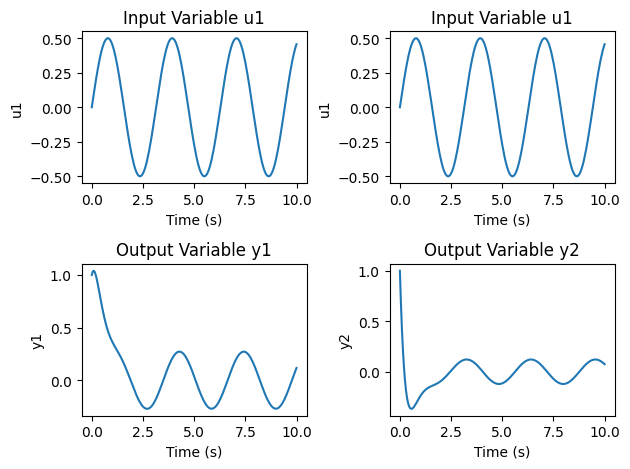

In [296]:
plt.figure()

plt.subplot(2,2,1)
plt.plot(sol.t, u_values[:, 0])
plt.xlabel('Time (s)')
plt.ylabel('u1')
plt.title('Input Variable u1')

plt.subplot(2,2,2)
plt.plot(sol.t, u_values[:, 1])
plt.xlabel('Time (s)')
plt.ylabel('u1')
plt.title('Input Variable u1')

plt.subplot(2, 2, 3)
plt.plot(sol.t, y[:, 0])
plt.xlabel('Time (s)')
plt.ylabel('y1')
plt.title('Output Variable y1')

plt.subplot(2, 2, 4)
plt.plot(sol.t, y[:, 1])
plt.xlabel('Time (s)')
plt.ylabel('y2')
plt.title('Output Variable y2')

plt.tight_layout()
plt.show()

In [297]:
# Sample DataFrame
data = {
    'time':  tspan,
    'a': u_values[:,0],
    'b': u_values[:,1],
    'c': y[:,0],
    'd': y[:,1]
}
df = pd.DataFrame(data)

# Ensure time is the index
df.set_index('time', inplace=True)

def create_sequences(df, seq_length):
    inputs = []
    outputs = []

    for i in range(len(df) - seq_length):
        inputs.append(df[['c', 'd']].iloc[i:i+seq_length].values)
        outputs.append(df[['a', 'b']].iloc[i+seq_length].values)

    return np.array(inputs), np.array(outputs)

seq_length = 10  # Example sequence length
X, y = create_sequences(df, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

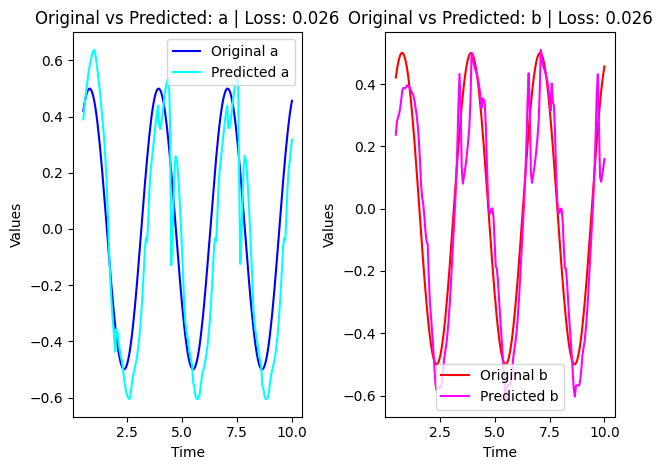

In [298]:
model.eval()

with torch.no_grad():
    predictions = model(X)
    loss = criterion(predictions, y)

# Convert predictions to numpy array for plotting
predictions_np = predictions.numpy()
y_np = y.numpy()

# Create a new DataFrame for plotting
pred_df = pd.DataFrame(predictions_np, columns=['pred_a', 'pred_b'])
orig_df = pd.DataFrame(y_np, columns=['orig_a', 'orig_b'])

# Add the time index
pred_df['time'] = df.index[seq_length:]
orig_df['time'] = df.index[seq_length:]

# Plot the original and predicted data
plt.figure()

# Plot 'a'
plt.subplot(1, 2, 1)
plt.plot(orig_df['time'], orig_df['orig_a'], label='Original a', color='blue')
plt.plot(pred_df['time'], pred_df['pred_a'], label='Predicted a', color='cyan')
plt.title(f'Original vs Predicted: a | Loss: {loss:.3f}')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Plot 'b'
plt.subplot(1, 2, 2)
plt.plot(orig_df['time'], orig_df['orig_b'], label='Original b', color='red')
plt.plot(pred_df['time'], pred_df['pred_b'], label='Predicted b', color='magenta')
plt.title(f'Original vs Predicted: b | Loss: {loss:.3f}')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()